In [3]:
#When input image is selected, run it through models and make predictions 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras 
import numpy as np

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

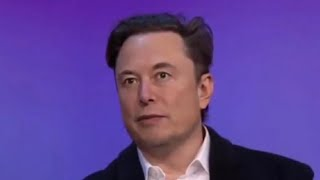

In [4]:
model_builder = keras.applications.xception.Xception
img_size = (128, 128)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv2d"

# The local path to our target image
img_path = 'C:\\Users\\624411\\Desktop\\Project_working\\MuskRat\\thisone\\test_internet\\fake_image\\elon_musk_fake.jpg'

display(Image(img_path))

In [5]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [6]:
IMG_SIZE = 128
CATEGORIES = ['real', 'fake']

model1 = keras.models.load_model('double_trained_model.h5')
model2 = keras.models.load_model('model_00_20.h5')
model3 = keras.models.load_model('model_20_40.h5')
model4 = keras.models.load_model('model_40_60.h5')
model5 = keras.models.load_model('model_q2_q4.h5')

MODELS = [model1, model2, model3, model4, model5]

In [7]:
#Function ingests a Lists, returns the most frequent value in list
def most_frequent(List):
    counter = 0
    num = List[0]
     
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
 
    return num

In [8]:
def prediction_array(img):
    pred = []

    for mod in MODELS:
        predictions = mod.predict(img)
        pred.append(int(predictions[0][0]))
    #append the most frequent result on total_pred list so that we return 1 list
    pred.append(most_frequent(pred))
    #print(pred)
    return pred

In [16]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

In [17]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    #setter has list in parameters
    def set_model(self, mod):
        self.model = mod

In [25]:
def find_target_layer(model):
	# attempt to find the final convolutional layer in the network
	# by looping over the layers of the network in reverse order
	for layer in reversed(model.layers):
		# check to see if the layer has a 4D output
		if len(layer.output_shape) == 4:
			return layer.name
	# otherwise, we could not find a 4D layer so the GradCAM
	# algorithm cannot be applied
	raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

In [22]:
def compute_heatmap(self, image, eps=1e-8):
    # construct our gradient model by supplying (1) the inputs
    # to our pre-trained model, (2) the output of the (presumably)
    # final 4D layer in the network, and (3) the output of the
    # softmax activations from the model
    gradModel = Model(
        inputs=[self.model.inputs],
        outputs=[self.model.get_layer(self.layerName).output,
            self.model.output])

In [28]:
def get_list_of_predictions(img_path):
    #parameter is path to input file on local machine 
    #convert image to grayscale 
    img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    #plt.imshow(img_array, cmap="gray")
    #plt.show()

    #resize image to fit model input layer
    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    img_array = img_array.reshape(-1, 128, 128, 1)
    #compute_heatmap(img_array)

    #i = 0
    temp_list = []
    #make a prediction with each model
    for mod in MODELS:
        target_layer_name = find_target_layer(mod)
        print(target_layer_name)
        predictions = mod.predict(img_array)
        temp_list.append(int(predictions[0][0]))

        #heatmap
        # Remove last layer's softmax
        mod.layers[-1].activation = None

        
        # Print what the top predicted class is
        preds = mod.predict(img_array)
        #print("Predicted Class Model " + str(i) + ": " + CATEGORIES[int(predictions[0][0])])
        #i = i + 1
    pred = prediction_array(img_array)
    print("hey")
    print("Predicted:", decode_predictions(pred, top=1)[0])
    #print("Predicted:", decode_predictions(preds, top=1)[0])

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, mod, last_conv_layer_name)

    # Display heatmap
    plt.matshow(heatmap)
    plt.show()
    #print("here")
    #print(pred)
    return pred

In [29]:
get_list_of_predictions(img_path)

1/1 [==============================] - 0s 24ms/step
hey


AttributeError: 'list' object has no attribute 'shape'